In [17]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
from keras.utils import np_utils

In [3]:
train = np.loadtxt('../../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [99]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

(28, 28)


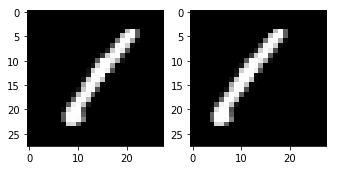

In [96]:
img = train_img[0]
img_r = img.shape[0]
img_c = img.shape[1]
train_img_moved = img
train_img_moved = np.zeros((img_r,img_c))
train_img_moved[:,0:img_c-3] = img[:,3:img_c]
print(train_img_moved.shape)
fig = plt.figure(figsize=(20, 10))
subplot = fig.add_subplot(1, 7, 1)
plt.imshow(img, cmap='gray');
subplot = fig.add_subplot(1, 7, 2)
plt.imshow(train_img_moved, cmap='gray');

In [100]:
def move_img_right(img):
    img_r = img.shape[0]
    img_c = img.shape[1]
    img_moved = img
    img_moved = np.zeros((img_r,img_c))
    img_moved[:,3:] = img[:,0:img_c-3]
    return img_moved 
def move_img_left(img):
    img_r = img.shape[0]
    img_c = img.shape[1]
    img_moved = img
    img_moved = np.zeros((img_r,img_c))
    img_moved[:,0:img_c-3] = img[:,3:img_c]
    return img_moved 
moved_imges = []
for i, img in enumerate(train_img):
    img_moved = move_img_right(img)
    moved_imges.append(img_moved)
train_img = np.append(train_img, moved_imges, axis=0)
train_label = np.append(train_label, train_label)
moved_imges = []
for i, img in enumerate(train_img[0:42000]):
    img_moved = move_img_left(img)
    moved_imges.append(img_moved)
train_img = np.append(train_img, moved_imges, axis=0)
train_label = np.append(train_label, train_label[0:42000])

In [107]:
train_label.shape
train_img.shape

(126000, 28, 28)

## Визуализируем исходные данные

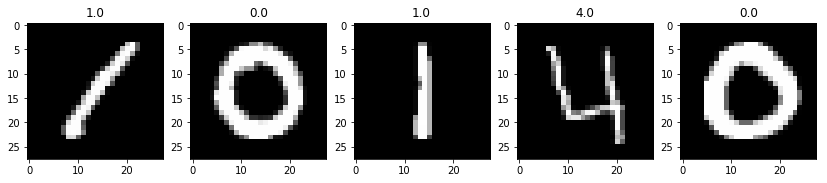

In [62]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [102]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [103]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

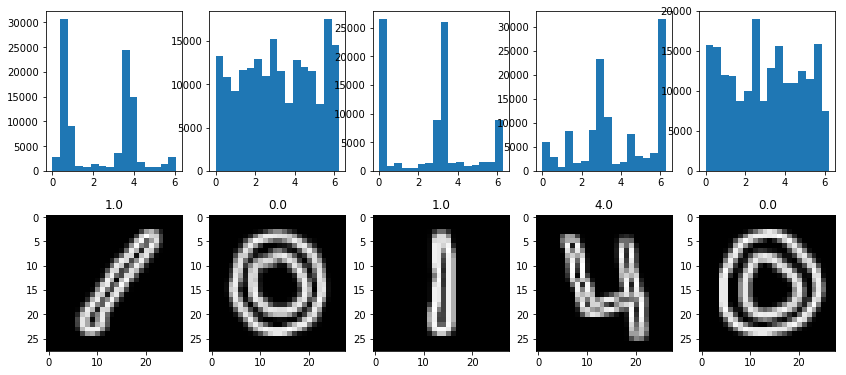

In [65]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [108]:
def divide_arr_in_four(arr):
    shape = arr.shape
    arr_divided = [arr[0:int(shape[0]/2), 0:int(shape[1]/2)],
                        arr[int(shape[0]/2 + 1):shape[0], 0:int(shape[1]/2)],
                        arr[0:int(shape[0]/2), int(shape[1]/2 + 1):shape[1]],
                        arr[int(shape[0]/2 + 1):shape[0], int(shape[1]/2+1):shape[1]]]
    return arr_divided
def convert_to_hist(img, theta, g, hist_bins,  norm):
    hists = np.zeros((len(img), 4*hist_bins))
    theta_normed = theta
    
    for i in range(len(img)):
        theta_divided = divide_arr_in_four(theta_normed[i])
        g_divided = divide_arr_in_four(g[i])
        hist_stacked = []
        for j in range(len(theta_divided)):
            hist, borders = np.histogram(theta_divided[j],
                                 bins=hist_bins,
                                 range=(0., 2. * np.pi),
                                 weights=g_divided[j])
            hist_stacked.extend(hist)
        hists[i] = hist_stacked
    # По умолчанию используется L2 норма
    if norm:
        hists = hists / np.linalg.norm(hists, axis=1)[:, None]
    return hists

best_hist_bin = 25
best_norm = True

train_hist = convert_to_hist(train_img, train_theta, train_g, best_hist_bin, best_norm)
test_hist = convert_to_hist(test_img, test_theta, test_g, best_hist_bin,  best_norm)
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist, test_size=0.2)

In [109]:
def get_hist_predictions_neur(x_train, y_train, x_val, y_val, test_hist):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(200, input_dim=x_train.shape[1], activation='relu'))
    model.add(keras.layers.Dense(100, input_dim=x_train.shape[1], activation='relu'))
    model.add(keras.layers.Dense(100, input_dim=x_train.shape[1], activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    y_train_labels = np_utils.to_categorical(y_train)
    model.fit(x_train, y_train_labels, batch_size=32, epochs=100)
    pred_val = model.predict_classes(x_val)
    print('Accuracy: %s' % accuracy_score(y_val, pred_val))
    return pred_val, model.predict_classes(test_hist)
pred_val, pred_test = get_hist_predictions_neur(x_train, y_train, x_val, y_val, test_hist)

Epoch 1/100
100800/100800 [==============================] - 43s - loss: 0.3331 - acc: 0.8938    
Epoch 2/100
100800/100800 [==============================] - 5s - loss: 0.1618 - acc: 0.9471     
Epoch 3/100
100800/100800 [==============================] - 5s - loss: 0.1255 - acc: 0.9582     
Epoch 4/100
100800/100800 [==============================] - 5s - loss: 0.1026 - acc: 0.9661     
Epoch 5/100
100800/100800 [==============================] - 5s - loss: 0.0880 - acc: 0.9704     
Epoch 6/100
100800/100800 [==============================] - 5s - loss: 0.0748 - acc: 0.9743     
Epoch 7/100
100800/100800 [==============================] - 5s - loss: 0.0647 - acc: 0.9781     
Epoch 8/100
100800/100800 [==============================] - 5s - loss: 0.0579 - acc: 0.9800     
Epoch 9/100
100800/100800 [==============================] - 5s - loss: 0.0505 - acc: 0.9828     
Epoch 10/100
100800/100800 [==============================] - 5s - loss: 0.0449 - acc: 0.9842     
Epoch 11/100
100800

100800/100800 [==============================] - 4s - loss: 0.0058 - acc: 0.9982     
Epoch 84/100
100800/100800 [==============================] - 4s - loss: 0.0067 - acc: 0.9979     
Epoch 85/100
100800/100800 [==============================] - 5s - loss: 0.0061 - acc: 0.9983     
Epoch 86/100
100800/100800 [==============================] - 5s - loss: 0.0069 - acc: 0.9979     
Epoch 87/100
100800/100800 [==============================] - 5s - loss: 0.0069 - acc: 0.9981     
Epoch 88/100
100800/100800 [==============================] - 4s - loss: 0.0064 - acc: 0.9982     
Epoch 89/100
100800/100800 [==============================] - 4s - loss: 0.0048 - acc: 0.9986     
Epoch 90/100
100800/100800 [==============================] - 4s - loss: 0.0071 - acc: 0.9979     
Epoch 91/100
100800/100800 [==============================] - 4s - loss: 0.0069 - acc: 0.9981     
Epoch 92/100
100800/100800 [==============================] - 5s - loss: 0.0054 - acc: 0.9985     
Epoch 93/100
100800/100

## Разбиваем выборку на обучение и валидацию

In [24]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Собираем полносвязную сеть для обучения

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, input_dim=x_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [ ]:
model.summary()

## One hot encoding разметки

In [30]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [33]:
model.fit(x_train, y_train_labels, batch_size=32, epochs=100)

Epoch 1/100
33600/33600 [==============================] - 1s - loss: 13.5884 - acc: 0.1568     
Epoch 2/100
33600/33600 [==============================] - 1s - loss: 13.3702 - acc: 0.1704     
Epoch 3/100
33600/33600 [==============================] - 1s - loss: 12.9762 - acc: 0.1949     
Epoch 4/100
33600/33600 [==============================] - 1s - loss: 12.9704 - acc: 0.1952     
Epoch 5/100
33600/33600 [==============================] - 1s - loss: 12.9075 - acc: 0.1991     
Epoch 6/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 7/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 8/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 9/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 10/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 11/100
33600/33600 [===

33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 85/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 86/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 87/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 88/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 89/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 90/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 91/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 92/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 93/100
33600/33600 [==============================] - 1s - loss: 12.9002 - acc: 0.1996     
Epoch 94/100
33600/33600 [=======

## Предсказываем класс объекта

In [23]:
pred_val = model.predict_classes(x_val)

6688/8400 [======================>.......] - ETA: 0s

## Оцениваем качество решение на валидационной выборке

In [24]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.0971428571429


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.10      1.00      0.18       816
        1.0       0.00      0.00      0.00       909
        2.0       0.00      0.00      0.00       846
        3.0       0.00      0.00      0.00       937
        4.0       0.00      0.00      0.00       839
        5.0       0.00      0.00      0.00       702
        6.0       0.00      0.00      0.00       785
        7.0       0.00      0.00      0.00       893
        8.0       0.00      0.00      0.00       835
        9.0       0.00      0.00      0.00       838

avg / total       0.01      0.10      0.02      8400



C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[816   0   0   0   0   0   0   0   0   0]
 [909   0   0   0   0   0   0   0   0   0]
 [846   0   0   0   0   0   0   0   0   0]
 [937   0   0   0   0   0   0   0   0   0]
 [839   0   0   0   0   0   0   0   0   0]
 [702   0   0   0   0   0   0   0   0   0]
 [785   0   0   0   0   0   0   0   0   0]
 [893   0   0   0   0   0   0   0   0   0]
 [835   0   0   0   0   0   0   0   0   0]
 [838   0   0   0   0   0   0   0   0   0]]


## Предсказания на тестовыйх данных

In [27]:
pred_test = model.predict_classes(test_hist)

26496/28000 [===========================>..] - ETA: 0s

## Визуализируем предсказания

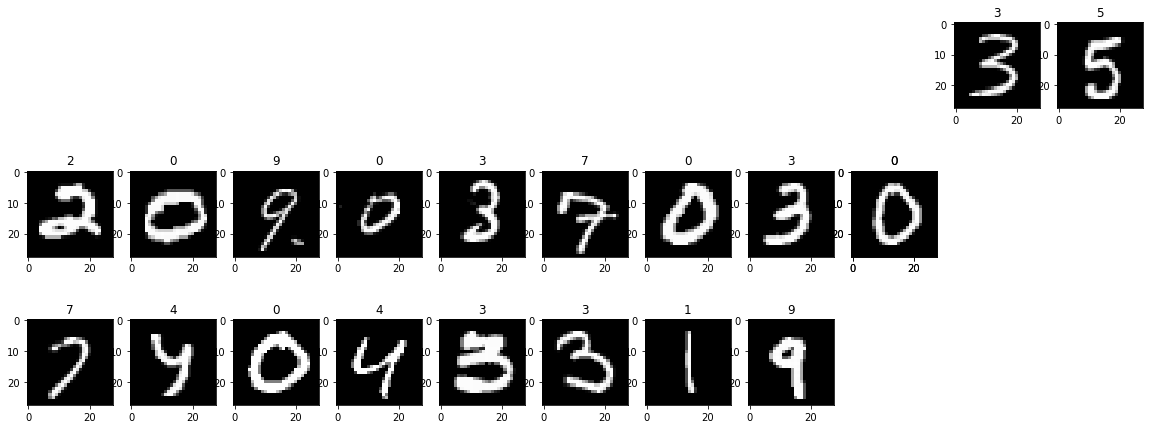

In [93]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(int(i / 10) + 1, 11, i % 10)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [94]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
# Your submission scored 0.59843